In [184]:
# All the libraries used
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import KMeans

import time
import random
import math

from scipy.ndimage import imread # Need to use scipy 1.1.0 to run imread
import scipy.ndimage
from scipy.misc import imresize
import scipy 

## Loading files

In [139]:
path = "/Users/haley/Desktop/CMPE 255/Rentinal Classification/gaussian_diabetic_retino/gaussian_filtered_images/gaussian_filtered_images/"
level = ["Mild","Moderate","No_DR","Proliferate_DR","Severe"]
file_id = []
lstFilesDCM = []
for i in level:    
    for dirName, subdirList, fileList in os.walk(path+i):
        # Randomly pick 20 images from each level
        random_images = random.choices(fileList,k=190)
        for filename in random_images: 
            file_id.append(filename)
            lstFilesDCM.append(os.path.join(dirName,filename))   

In [140]:
len(file_id) # Total number of data points

950

In [141]:
target = pd.read_csv("gaussian_diabetic_retino/train.csv")
target.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [142]:
# To get the target values corresponding to given target csv file
y = []
for i in range(len(file_id)):
    code = file_id[i][:-4] # Slice to get rid of .png at the end of str
    label = target['diagnosis'][target['id_code'] == code]
    y.append(int(label))
y = np.array(y)

## Applying Gaussian filter with Laplacian

* Read about how Laplacian of Gaussian works here: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm
* Using cv2 to apply this technique: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

In [143]:
# 0. Read the data into Numpy
n = len(lstFilesDCM)
one = np.zeros((n,224,224))

# 0.5 Transfer All of the Data into array
print('===== READING DATA ========')
for file_index in range(len(one)):
    one[file_index,:,:]   = imresize(imread(lstFilesDCM[file_index],mode='F',flatten=True),(224,224))
print('===== Done READING DATA ========')

===== READING DATA ========


/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


===== Done READING DATA ========


In [144]:
# LoG (Smooth) Function
data_array = []
for x in range(len(one)):
    s = 1.75
    temp = scipy.ndimage.filters.gaussian_filter(
        one[x,:,:],
        sigma = s
        )
    
    lap_kernel = np.array([
        [0,1,0],
        [1,-4,1],
        [0,1,0]
    ])

    result = cv2.filter2D(temp,-1,lap_kernel)
    data_array.append(result)
#     plt.axis('off')
#     plt.imshow(result,cmap='gray')
#     plt.savefig("LoG_images/"+ str(x) + '.png',bbox_inches='tight')
#     plt.show()
# -- end code --

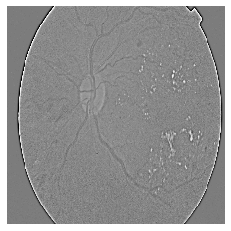

In [158]:
plt.axis('off')
plt.imshow(one[-1],cmap='gray')
plt.show()

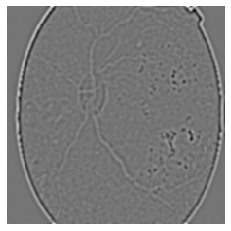

In [159]:
plt.axis('off')
plt.imshow(result,cmap='gray')
plt.show()

## Reshaping and splitting dataset

In [145]:
data_array = np.array(data_array).flatten().reshape(n,-1)

In [146]:
data_array.shape

(950, 50176)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(data_array,y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(665, 50176), (665,)
Test data and target sizes: 
(285, 50176), (285,)


## Data Preprocessing, Training and Testing

**PCA + SVM**

In [202]:
# Preprocessing with PCA
reduced_pca = PCA(n_components=0.8)
reduced_pca.fit(X_train)
X_train_reduced = reduced_pca.transform(X_train)
X_test_reduced = reduced_pca.transform(X_test)

In [203]:
# Number of PCA used to retained the percentage set for n_components
len(reduced_pca.explained_variance_ratio_)

68

In [204]:
reduced_pca.explained_variance_ratio_

array([0.3764938 , 0.0723025 , 0.05012261, 0.03482416, 0.02600314,
       0.02326063, 0.01954832, 0.01728206, 0.01259431, 0.01001995,
       0.0087657 , 0.00627859, 0.00559112, 0.00528948, 0.00473813,
       0.00445962, 0.00426471, 0.00413451, 0.00401714, 0.00381976,
       0.0036889 , 0.00361079, 0.00358204, 0.00338614, 0.00333524,
       0.00326502, 0.00311013, 0.00308767, 0.00303906, 0.00297562,
       0.00292702, 0.00282911, 0.00280632, 0.00274909, 0.0026889 ,
       0.00259378, 0.00245994, 0.00234895, 0.00233289, 0.00230495,
       0.00224033, 0.00218088, 0.00210952, 0.00204376, 0.00200756,
       0.00194879, 0.00190264, 0.00187859, 0.00184182, 0.00180556,
       0.00175922, 0.00173335, 0.00171249, 0.0016833 , 0.00166997,
       0.00165802, 0.00163695, 0.00157596, 0.0015646 , 0.0015465 ,
       0.00153165, 0.0015055 , 0.00148202, 0.00144078, 0.00141088,
       0.00140114, 0.00139143, 0.00138483])

In [205]:
X_train_reduced.shape

(665, 68)

In [206]:
clf = svm.SVC(gamma='auto')
starting_time = time.process_time()
clf.fit(X_train_reduced,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", clf.score(X_test_reduced, y_test))

Data fitting takes 0.3985739999998259 seconds
Testing Accuracy 0.4421052631578947


**KMeans + SVM**

In [207]:
# Preprocessing with KMeans
# Rule of thumb for picking K
k = math.sqrt(X_train.shape[0]/2)
kmnist_kmeans = KMeans(n_clusters=int(k), max_iter = 1000).fit(X_train)
X_train_cluster = kmnist_kmeans.transform(X_train)
X_test_cluster = kmnist_kmeans.transform(X_test)

In [208]:
X_train_cluster.shape

(665, 18)

In [209]:
clf = svm.SVC(gamma=0.001)
starting_time = time.process_time()
clf.fit(X_train_cluster,y_train)
print("Data fditting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", clf.score(X_test_cluster, y_test))

Data fditting takes 0.18029400000023088 seconds
Testing Accuracy 0.5157894736842106
